# Ananke

This notebook is based on the example notebook in py-ananke's repository "https://github.com/athob/py-ananke/tree/main"


In [1]:
import ananke

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import h5py

In [5]:
from astropy import coordinates as ac
from astropy import units as u

In [6]:
idx_f = 178

In [7]:
snapname = f"/astro/dboyea/sculptor/orbits/orbit1/1e6_V32_r5.4/out/snapshot_{idx_f - 1}.hdf5"

In [8]:
starsname = "/astro/dboyea/sculptor/isolation/1e6/fiducial/stars_ana/exp2d_rs0.10_stars.hdf5"

In [9]:
with h5py.File(snapname) as h5f:
    pos = np.array(h5f["PartType1/Coordinates"])
    vel = np.array(h5f["PartType1/Velocities"])
    index =  np.array(h5f["PartType1/ParticleIDs"])

In [10]:
with h5py.File(starsname) as h5f:
    stars_index = np.array(h5f["index"])
    probabilities = np.array(h5f["probability"])
stars_index, probabilities

(array([      1,       2,       3, ...,  999998,  999999, 1000000]),
 array([2.22934815e-251, 0.00000000e+000, 0.00000000e+000, ...,
        4.10473853e-152, 4.17184933e-020, 3.90043577e-122]))

In [11]:
def invperm(a):
    b = np.arange(a.shape[0])
    b[a] = b.copy()
    return b

In [12]:
mtot = 2.7e6
mstar = probabilities[invperm(np.argsort(index))] * mtot

In [13]:
stars_index[invperm(np.argsort(index))] == index

array([ True,  True,  True, ...,  True,  True,  True])

In [14]:
sum(mstar)

2699999.9999997155

In [15]:
N = len(mstar)
V0 = 207.4

sim_input = {
    "pos3": pos,
    "vel3": vel * V0,
    "mass": mstar,
    "age": np.random.normal(9.8, 0.1, N),
    "feh": np.random.normal(-2.3, 0.25, N),
    "parentid": index,
    
}

In [16]:
vel.shape

(1000000, 3)

In [17]:
sim_input

{'pos3': array([[ -5.2127695 , -12.5378    , -78.9448    ],
        [ -5.1854053 , -12.550253  , -78.97125   ],
        [ -5.278691  , -12.517465  , -78.92486   ],
        ...,
        [ 61.682835  ,   0.82146645, 109.0447    ],
        [ 61.751995  ,   0.11749478, 105.75171   ],
        [ 59.891254  ,   2.4718196 , 105.56893   ]], dtype=float32),
 'vel3': array([[   7.480167,  150.54129 , -132.79074 ],
        [  10.748213,  141.43848 ,  -91.20764 ],
        [  27.622059,  149.05194 ,  -92.24296 ],
        ...,
        [  60.32314 ,  -12.842017,  157.33994 ],
        [ -84.50634 , -112.07396 ,  120.116684],
        [  67.69617 ,  -14.088097,  161.60738 ]], dtype=float32),
 'mass': array([2.00700905e-14, 8.04773439e-01, 1.99264176e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'age': array([9.88840989, 9.88216218, 9.69739889, ..., 9.76539241, 9.99633726,
        9.81240059]),
 'feh': array([-2.46863268, -2.18473925, -2.1779568 , ..., -1.89936859,
        -1.891357

In [18]:
idxs = np.random.choice(N, p=mstar/np.sum(mstar), size=10000)

In [19]:
gcs = ac.Galactocentric(x=pos[idxs, 0]*u.kpc, y=pos[idxs, 1]*u.kpc, z=pos[idxs, 2]*u.kpc);

In [20]:
icrs = gcs.transform_to(ac.ICRS())

In [21]:
V0 = 207 # km/s

In [22]:
help(ananke.Ananke)

Help on class Ananke in module ananke.Ananke:

class Ananke(builtins.object)
 |  Ananke(particles: Dict[str, numpy.ndarray[Any, numpy.dtype[+_ScalarType_co]]], name: str, ngb: int = 64, d_params: Dict[str, Any] = {}, e_params: Dict[str, Any] = {}, err_params: Dict[str, Any] = {}, **kwargs: Dict[str, Any]) -> None
 |  
 |  Represents a single ananke pipeline.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, particles: Dict[str, numpy.ndarray[Any, numpy.dtype[+_ScalarType_co]]], name: str, ngb: int = 64, d_params: Dict[str, Any] = {}, e_params: Dict[str, Any] = {}, err_params: Dict[str, Any] = {}, **kwargs: Dict[str, Any]) -> None
 |      Parameters
 |      ----------
 |      particles : dict
 |          A dictionary of same-length arrays representing particles
 |          data of a stellar population - see notes for formatting
 |      
 |      name : str
 |          Name for the pipeline
 |      
 |      ngb : int
 |          Number of neighbours to use in kernel density estimatio

In [23]:
# matches my GC coordinate definition
observer = {
    "pos3": [8.122, 0, 0.0208],
    "vel3": [ 12.9, 245.6, 7.78],
}

rshell = [0, 1000]

fsample = 1

photo_sys = 'padova/GAIA__DR2'

cmd_magnames = {'magnitude': 'G',
                'color_minuend': 'Gbp',
                'color_subtrahend': 'Grp'}

cmd_box = {
           'abs_mag_lim_lo': -1000,
           'abs_mag_lim_hi': 1000,
        #    'app_mag_lim_lo' : -1000,
           'app_mag_lim_hi': 30,
        #    'color_lim_lo' : -1000,
        #    'color_lim_hi' : 1000
           }

In [24]:
name = "fiducial"

an = ananke.Ananke(sim_input, name, 
    fsample=fsample, observe=observer, rshell=rshell, photo_sys=photo_sys, cmd_magnames=cmd_magnames, **cmd_box)


/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


In [25]:
survey = an.run()

Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 3000000 records
Allocated 38.147 MByte for particle storage.
Type = 1 Particles = 1000000
Total particles = 1000000
Allocated 221.252 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 1999999
Total number of nodes = 1999999
Treebuild time = 1.98804 s 

Density Calculation. Smoothing .....
Evaluated =   1 % Time Left = 10.390733 s of 10.495700 s Par no = 802239 Density = 1.715021e+00 
Evaluated =   2 % Time Left = 11.142883 s of 11.370300 s Par no = 301024 Density = 1.411257e+00 
Evaluated =   3 % Time Left = 11.284483 s of 11.633500 s Par no = 614020 Density = 8.121975e-01 
Evaluated =   4 % Time Left = 11.342772 s of 11.815400 s Par no = 371155 Density = 1.804440e+00 
Evaluated =   5 % Time Left = 11.054188 s of 11.636000 s

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 3000000 records
Allocated 38.147 MByte for particle storage.
Type = 1 Particles = 1000000
Total particles = 1000000
Allocated 221.252 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 1999999
Total number of nodes = 1999999
Treebuild time = 2.67672 s 

Density Calculation. Smoothing .....
Evaluated =   1 % Time Left = 11.861079 s of 11.980900 s Par no = 745305 Density = 3.383488e-01 
Evaluated =   2 % Time Left = 12.186435 s of 12.435150 s Par no = 603675 Density = 1.960398e-01 
Evaluated =   3 % Time Left = 12.260917 s of 12.640133 s Par no = 727475 Density = 1.830237e-01 
Evaluated =   4 % Time Left = 12.202451 s of 12.710900 s Par no = 355743 Density = 6.991402e-02 
Evaluated =   5 % Time Left = 12.024878 s of 12.657780 s

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Executing JOB 1/1 = /arc7/home/dboyea/.local/.cache/Galaxia_ananke/bin/galaxia -r --hdim=6 --nfile=fiducial --ngen=0 /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | CODEDATAPATH=/arc7/home/dboyea/.local/.cache/Galaxia_ananke/GalaxiaData/
JOB 1/1 | Reading Parameter file-             /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | --------------------------------------------------------
JOB 1/1 | outputFile               survey                  
JOB 1/1 | outputDir                /arc7/home/dboyea/dwarfs/notebooks
JOB 1/1 | photoCateg               padova                  
JOB 1/1 | photoSys                 GAIA__DR2               
JOB 1/1 | magcolorNames            G,Gbp-Grp               
JOB 1/1 | appMagLimits[0]          -1000                   
JOB 1/1 | appMagLimits[1]          30                      
JOB 1/1 | absMagLimits[0]          -1000                   
JOB 1/1 | absMagLimits[1]          1000                    
JOB 1/1 | colorLimits[0]           -100

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


Exported the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.fiducial.0.h5
['gaia__dr2_grp_Sig', 'ra_Err', 'pi_Sig', 'mura_Sig', 'pi_Err', 'dec_Err', 'dec_Sig', 'gaia__dr2_grp_Err', 'mudec_Err', 'gaia__dr2_gbp_Sig', 'gaia__dr2_g_Err', 'mudec_Sig', 'vr_Err', 'vr_Sig', 'mura_Err', 'gaia__dr2_g_Sig', 'gaia__dr2_gbp_Err', 'ra_Sig']
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.fiducial.0.h5
('gaia__dr2_g', 'gaia__dr2_gbp', 'dec', 'mudec', 'ra', 'mura', 'gaia__dr2_grp', 'vr', 'pi')
Running convert_icrs_to_galactic post-processing pipeline
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.fiducial.0.h5
('glon', 'glat', 'mul', 'mub')


In [26]:
survey

#,age,dec,dec_Err,dec_Sig,dform,dmod,feh,gaia__dr2_g,gaia__dr2_g_Err,gaia__dr2_g_Intrinsic,gaia__dr2_g_Sig,gaia__dr2_gbp,gaia__dr2_gbp_Err,gaia__dr2_gbp_Intrinsic,gaia__dr2_gbp_Sig,gaia__dr2_grp,gaia__dr2_grp_Err,gaia__dr2_grp_Intrinsic,gaia__dr2_grp_Sig,glat,glon,grav,lum,mact,mtip,mub,mudec,mudec_Err,mudec_Sig,mul,mura,mura_Err,mura_Sig,parentid,partid,partitionid,pi,pi_Err,pi_Sig,px,py,pz,ra,ra_Err,ra_Sig,rad,smass,teff,vr,vr_Err,vr_Sig,vx,vy,vz
0,9.882162094116211,nan,nan,nan,0.0,19.51644642585769,-2.184739351272583,nan,nan,8.701857,nan,nan,nan,9.295034,nan,nan,nan,7.9795012,nan,nan,nan,5.0111203,0.02983682,0.3232893,0.9314372,nan,nan,nan,nan,nan,nan,nan,nan,909254,0,0,nan,nan,nan,2.9365681117429343,-12.550252914413981,-78.99205244143673,nan,nan,nan,80.03672050628606,0.3235771392208268,4433.857,nan,nan,nan,-2.1517871856689457,-104.1615234375,-98.9876416015625
1,9.697399139404297,nan,nan,nan,0.0,19.514972803181852,-2.1779568195343018,nan,nan,8.803594,nan,nan,nan,9.40308,nan,nan,nan,8.076375,nan,nan,nan,5.0237527,0.027308848,0.31113282,1.0683813,nan,nan,nan,nan,nan,nan,nan,nan,439699,0,0,nan,nan,nan,2.843282551135024,-12.517464637741618,-78.9456580932922,nan,nan,nan,79.98242374675634,0.3113940716303245,4411.5996,nan,nan,nan,14.722058868408203,-96.54805908203124,-100.02295806884766
2,9.697399139404297,nan,nan,nan,0.0,19.51333746616942,-2.1779568195343018,nan,nan,9.479135,nan,nan,nan,10.123109,nan,nan,nan,8.721699,nan,nan,nan,5.0986786,0.015223652,0.23431252,1.0683813,nan,nan,nan,nan,nan,nan,nan,nan,439699,1,0,nan,nan,nan,2.8026046115460286,-12.471850606924752,-78.89333469696051,nan,nan,nan,79.92221161715146,0.2348605234494832,4275.7983,nan,nan,nan,14.816171910345963,-96.71469517093364,-99.8836470674518
3,9.697399139404297,nan,nan,nan,0.0,19.514273549326823,-2.1779568195343018,nan,nan,10.080817,nan,nan,nan,10.767511,nan,nan,nan,9.295158,nan,nan,nan,5.170547,0.009039484,0.18351056,1.0683813,nan,nan,nan,nan,nan,nan,nan,nan,439699,1,0,nan,nan,nan,2.877118740641792,-12.455641111206917,-78.92812302227135,nan,nan,nan,79.95667208906171,0.18437420458941603,4156.7544,nan,nan,nan,14.976365983704452,-96.75317229839779,-100.02816251247532
4,9.697399139404297,nan,nan,nan,0.0,19.514915231876135,-2.1779568195343018,nan,nan,5.727094,nan,nan,nan,6.0071936,nan,nan,nan,5.266175,nan,nan,nan,4.6809196,0.41033873,0.69508064,1.0683813,nan,nan,nan,nan,nan,nan,nan,nan,439699,1,0,nan,nan,nan,2.850339029538103,-12.521712254388333,-78.94258163557348,nan,nan,nan,79.98030323557288,0.6945983047566759,5829.62,nan,nan,nan,14.721925092968618,-96.5870126869185,-100.39724962907667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,515,026",9.988815307617188,nan,nan,nan,0.0,19.263979630749294,-2.118443012237549,nan,nan,9.265436,nan,nan,nan,9.897363,nan,nan,nan,8.5167,nan,nan,nan,5.0639005,0.018334832,0.25105155,0.87040883,nan,nan,nan,nan,nan,nan,nan,nan,383670,1,0,nan,nan,nan,4.627979672353654,-0.29382188155407857,-71.10074884103246,nan,nan,nan,71.25181410252918,0.25130064439683514,4312.3135,nan,nan,nan,8.519134549666546,-79.42293335741068,-57.43438633257355
"2,515,027",9.988815307617188,nan,nan,nan,0.0,19.26278433179164,-2.118443012237549,nan,nan,9.658558,nan,nan,nan,10.31602,nan,nan,nan,8.892022,nan,nan,nan,5.1087837,0.013045765,0.21235852,0.87040883,nan,nan,nan,nan,nan,nan,nan,nan,383670,1,0,nan,nan,nan,4.769742127028139,-0.526873715521663,-71.05073486070019,nan,nan,nan,71.21260394140894,0.21329855838210351,4236.154,nan,nan,nan,7.506523042727052,-79.9956185851137,-58.08714875270416
"2,515,028",9.917041778564453,nan,nan,nan,0.0,19.216416852569164,-1.9584547281265259,nan,nan,9.714189,nan,nan,nan,10.413787,nan,nan,nan,8.920691,nan,nan,nan,5.092016,0.012832515,0.22300285,0.90260226,nan,nan,nan,nan,nan,nan,nan,nan,786342,0,0,nan,nan,nan,3.9158490603818503,1.796012163176961,-69.57486951907345,nan,

In [27]:
observable = survey[~survey.dec.isna()]
observable

#,age,dec,dec_Err,dec_Sig,dform,dmod,feh,gaia__dr2_g,gaia__dr2_g_Err,gaia__dr2_g_Intrinsic,gaia__dr2_g_Sig,gaia__dr2_gbp,gaia__dr2_gbp_Err,gaia__dr2_gbp_Intrinsic,gaia__dr2_gbp_Sig,gaia__dr2_grp,gaia__dr2_grp_Err,gaia__dr2_grp_Intrinsic,gaia__dr2_grp_Sig,glat,glon,grav,lum,mact,mtip,mub,mudec,mudec_Err,mudec_Sig,mul,mura,mura_Err,mura_Sig,parentid,partid,partitionid,pi,pi_Err,pi_Sig,px,py,pz,ra,ra_Err,ra_Sig,rad,smass,teff,vr,vr_Err,vr_Sig,vx,vy,vz
0,9.830169677734375,-35.69649,3.428147664793803e-07,3.5613357e-07,0.0,19.527845267802,-2.048586130142212,20.571371,-0.0073772829497448355,1.0509039,0.0138351,20.85922,-0.06437623028811433,1.395752,0.31566006,19.734573,-0.3220441343280284,0.5287731,0.31566006,-80.81073,-77.29877,2.8008654,30.67052,0.9572827,0.96377873,-2.1185125075144553,2.1222905088494604,2.288492582062692,2.035682,-0.4269322913246187,-0.4077371223650802,-0.4784357217729674,2.035682,414971,1,0,0.30732106822524957,0.29489221823218487,1.2820808,2.8250366209566953,-12.534424148623208,-79.4253851082496,16.758532,4.5032353117050304e-07,3.5613357e-07,80.45796679161792,0.960028757835991,5360.1387,nan,nan,nan,18.160103219424194,-84.8107909555768,-104.78497239389102
1,9.812021255493164,-35.24024,1.6766477231856286e-08,8.398819e-08,0.0,19.52060898661109,-2.6201748847961426,19.139626,0.0035102775815402053,-0.3844936,0.0061912714,19.491344,-0.042638290312363825,0.013374107,0.10154807,18.530863,-0.03591776503405299,-0.9538282,0.10154807,-81.3134,-77.13739,2.136654,116.970825,0.957,0.96377873,-0.777234151860784,0.9512302813845994,1.1361136400904959,0.5800522,-0.6161003031226157,0.28077300589983195,0.17229044473816174,0.5800522,474955,1,0,0.060490389732384305,0.048020052370289064,0.30235747,2.696104468403843,-11.807217685814118,-79.2704461588211,16.49767,-3.8245843532136554e-08,8.398819e-08,80.19029244867052,0.9629669057949819,5109.1987,nan,nan,nan,9.99432821038879,-97.522872630313,-103.16532502771571
2,9.871861457824707,-35.135727,1.081792878456194e-08,1.5502044e-08,0.0,19.525966556518068,-1.917374849319458,16.385899,4.478321101131452e-05,-3.140112,0.0014573336,17.066994,-0.011190086184090736,-2.4477828,0.012887788,15.60114,-0.0008512312787767606,-3.9239752,0.012887788,-81.36404,-78.13931,0.6655466,1772.5162,0.88680124,0.9337453,0.20671585968572526,-0.23546956389098944,-0.06333881237536217,0.12222562,0.11560807601821887,-0.025509940717722335,-0.13571141387749816,0.12222562,383324,1,0,-0.02584492175746872,-0.038284529577616216,0.05580736,2.4809423053413147,-11.813088852090791,-79.47696851049359,16.644533,2.2918898788881673e-08,1.5502044e-08,80.3883863911188,0.9345367311460846,4405.8247,nan,nan,nan,6.396603000281706,-93.62031909612773,-100.46348510218301
3,9.717507362365723,-35.467697,1.7906800488558315e-07,1.1915592e-07,0.0,19.516879606149374,-2.180697441101074,19.50506,0.0024243531447077165,-0.014243655,0.0075825686,19.618698,-0.1217673930009957,0.22358546,0.13528877,19.245626,0.14023391002632407,-0.4114873,0.13528877,-80.92437,-79.27869,2.6383054,77.91514,1.0,1.0320942,-0.085162770319001,0.1680962064078887,0.34152167820287566,0.7862066,-0.21918204628771093,0.16442972581332166,0.07126773414915698,0.7862066,419221,1,0,0.20663747939178154,0.19414570653208243,0.4289613,2.3490971586265736,-12.406926191095064,-79.05050816558229,17.057968,9.358252706854192e-08,1.1915592e-07,80.05268837589865,1.0364639151707342,6096.518,nan,nan,nan,12.382105767479564,-92.3329024179793,-109.806889930415
4,9.81590461730957,-35.482536,2.1076014251709607e-07,1.6911989e-07,0.0,19.519967323998813,-2.4517710208892822,19.851627,-0.003871776162273402,0.33553112,0.009227174,19.999308,-0.2244731450023239,0.7038144,0.17849511,19.50001,0.18779463512872557,-0.20775215,0.17849511,-80.956345,-78.59145,2.4721384,59.69483,0.958,0.96377873,2.2576650486386245,-1.9017972786766062,-1.7587328816064844,1.0656015,-0.41501333252883027,1.2854783285475162,1.1819663775152192,1.0656015,174669,1,0,0.3505824268719323,0.3381084040236325,0.6088316,2.492551025323928,-12.352163159933859,-

Text(0, 0.5, 'dec / degree')

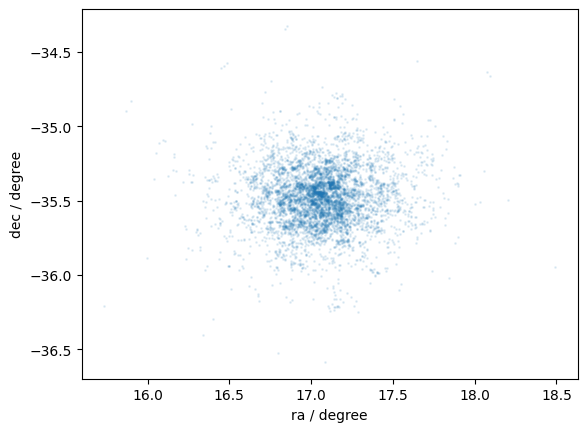

In [28]:
plt.scatter(observable.ra.values, observable.dec.values, alpha=0.1, s=1)
plt.xlabel("ra / degree")
plt.ylabel("dec / degree")

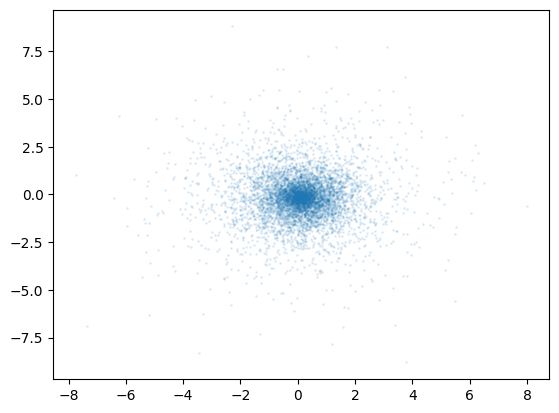

In [29]:
plt.scatter(observable.mura.values, observable.mudec.values, alpha=0.1, s=1)

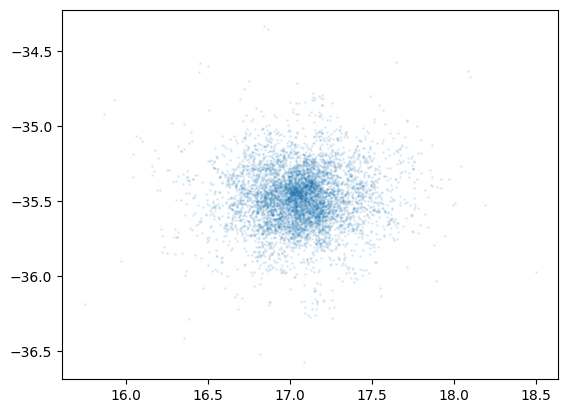

In [30]:
dd = 5
plt.scatter(observable.ra.values + np.random.normal(0, 0.02, len(observable)),
            observable.dec.values + np.random.normal(0, 0.02, len(observable)), alpha=0.1, s=1)

Text(0, 0.5, 'G')

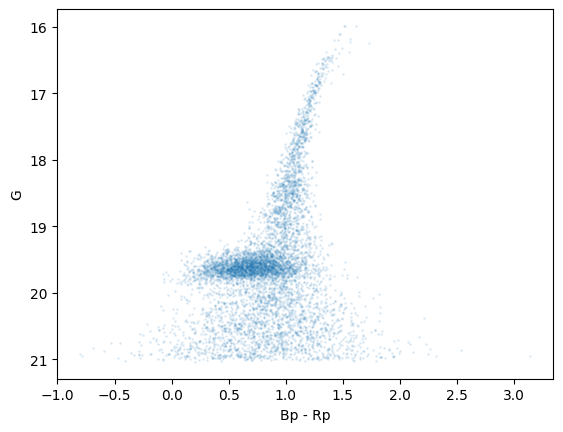

In [31]:
plt.scatter(observable.gaia__dr2_gbp.values - observable.gaia__dr2_grp.values, observable.gaia__dr2_g.values, s=1, alpha=0.1)
plt.gca().invert_yaxis()
plt.xlabel("Bp - Rp")
plt.ylabel("G")

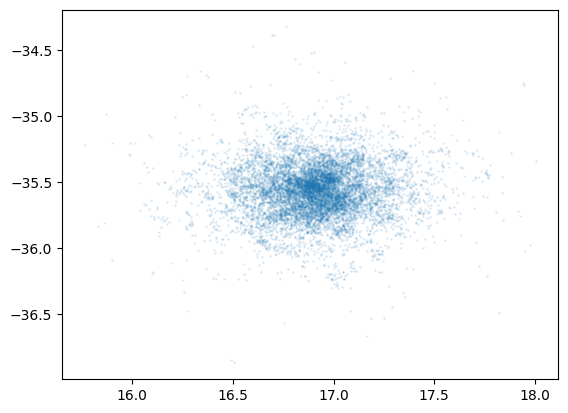

In [32]:

plt.scatter(icrs.ra + np.random.normal(0, 0.02, len(icrs))*u.degree, icrs.dec + np.random.normal(0, 0.02, len(icrs))*u.degree, s=1, alpha=0.1)

In [33]:
icrs.ra

<Longitude [17.04458276, 16.96881479, 17.07598789, ..., 16.94374043,
            16.73897795, 17.0296803 ] deg>

In [34]:
observable["pmra"] = observable.mura
observable["pmdec"] = observable.mudec

observable["pmra_error"] = observable.mura_Err
observable["pmdec_error"] = observable.mudec_Err

observable["G"] = observable.gaia__dr2_g
observable["G_err"] = observable.gaia__dr2_g_Err
observable["bp_rp"] = observable.gaia__dr2_gbp - observable.gaia__dr2_grp
observable["bp_rp_err"] = observable.gaia__dr2_gbp - observable.gaia__dr2_grp

In [35]:
observable["distance"] = 10 * 10 ** (1/5 * observable.dmod) / 1e3

In [36]:
df = observable[["ra", "dec", "pmra", "pmdec", "pmra_error", "pmdec_error", "G", "bp_rp", "distance"]].to_pandas_df()
df["weights"] = 1 / len(df)

In [37]:
from astropy.io import fits
from astropy.table import Table

In [38]:
tab = Table.from_pandas(df)


In [39]:
tab

ra,dec,pmra,pmdec,pmra_error,pmdec_error,G,bp_rp,distance,weights
float32,float32,float64,float64,float64,float64,float32,float32,float64,float64
16.758532,-35.69649,-0.4077371223650802,2.1222905088494604,-0.4784357217729674,2.288492582062692,20.571371,1.1246471,80.45796679161803,0.00015571473061351605
16.49767,-35.24024,0.28077300589983195,0.9512302813845994,0.17229044473816174,1.1361136400904959,19.139626,0.96048164,80.1902924486705,0.00015571473061351605
16.644533,-35.135727,-0.025509940717722335,-0.23546956389098944,-0.13571141387749816,-0.06333881237536217,16.385899,1.4658537,80.38838639111879,0.00015571473061351605
17.057968,-35.467697,0.16442972581332166,0.1680962064078887,0.07126773414915698,0.34152167820287566,19.50506,0.37307167,80.05268837589871,0.00015571473061351605
16.920612,-35.482536,1.2854783285475162,-1.9017972786766062,1.1819663775152192,-1.7587328816064844,19.851627,0.4992981,80.16659999434734,0.00015571473061351605
16.97623,-35.528538,-0.3101768986359487,0.07883021174366311,-0.42113544535353936,0.24414377672570897,19.743464,0.6672859,80.18010401559569,0.00015571473061351605
...,...,...,...,...,...,...,...,...,...
16.796202,-36.52286,-0.028192149961939986,-0.050368850807054,-0.11346872232436306,0.12118326901392201,19.232656,0.79187775,81.0986505519659,0.00015571473061351605
16.678238,-36.140873,0.1526434015739679,-0.7380758575314476,0.044449011563394404,-0.5628788378449204,18.879513,0.8935528,80.913845164167,0.00015571473061351605


In [40]:
outfile = "anake_test.fits"

hdu = fits.BinTableHDU(tab)
hdu.writeto(outfile, overwrite=True)

In [41]:
pwd()

'/arc7/home/dboyea/dwarfs/notebooks'